In [9]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [10]:
# Set path - CORRECTED PATH
folder_path = Path(r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3")
num_images = 240  # image_0000.png to image_0239.png

In [11]:
# Check if folder exists
if not folder_path.exists():
    print(f"ERROR: Folder not found at {folder_path}")
    print("Please check the path and try again.")
    exit()
else:
    print(f"Folder found: {folder_path}")
    # List first few files to verify
    files = sorted(folder_path.glob("*.png"))
    print(f"Found {len(files)} PNG files")
    if files:
        print(f"First file: {files[0].name}")
        print(f"Last file: {files[-1].name}")

Folder found: C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3
Found 240 PNG files
First file: image_0000.png
Last file: image_0239.png


In [12]:
# Store intensity values at screen center for each frame
intensities = []
frame_numbers = []

print("\nReading images and analyzing...")

for i in range(num_images):
    # Create filename
    filename = f"image_{i:04d}.png"
    filepath = folder_path / filename
    
    # Read image
    img = cv2.imread(str(filepath))
    
    if img is None:
        # Try to debug why it's not reading
        if not filepath.exists():
            print(f"File does not exist: {filepath}")
        else:
            print(f"File exists but cannot read: {filepath}")
        continue
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Get intensity at screen center (horizontal line through middle)
    height, width = gray.shape
    center_y = height // 2
    
    # Take average of center row (±10 pixels vertically to reduce noise)
    center_intensity = np.mean(gray[center_y-10:center_y+10, :])
    
    intensities.append(center_intensity)
    frame_numbers.append(i)
    
    if i % 50 == 0:
        print(f"Processed {i}/{num_images} images")

print(f"Finished reading {len(intensities)} images")



Reading images and analyzing...
Processed 0/240 images
Processed 50/240 images
Processed 100/240 images
Processed 150/240 images
Processed 200/240 images
Finished reading 240 images


In [13]:
# Convert list to numpy array
intensities = np.array(intensities)

# Apply smoothing to reduce noise
smoothed_intensities = gaussian_filter1d(intensities, sigma=2)

# Find valleys (dark fringes) - these are local minima
# Use scipy's find_peaks on inverted signal to find valleys
valleys, valley_properties = find_peaks(-smoothed_intensities, 
                                         prominence=2,  # Adjust if needed
                                         distance=3)    # Minimum distance between peaks

# Find peaks (bright fringes) - these are local maxima
peaks, peak_properties = find_peaks(smoothed_intensities, 
                                     prominence=2,     # Adjust if needed
                                     distance=3)       # Minimum distance between peaks

In [14]:
# Number of dark fringes that passed through center
num_dark_fringes = len(valleys)
num_bright_fringes = len(peaks)

print(f"\n{'='*60}")
print(f"Analysis Results:")
print(f"{'='*60}")
print(f"Number of DARK fringes passed through center: {num_dark_fringes}")
print(f"Number of BRIGHT fringes passed through center: {num_bright_fringes}")
print(f"Total fringe cycles: {(num_dark_fringes + num_bright_fringes) / 2:.1f}")
print(f"{'='*60}")


Analysis Results:
Number of DARK fringes passed through center: 0
Number of BRIGHT fringes passed through center: 0
Total fringe cycles: 0.0


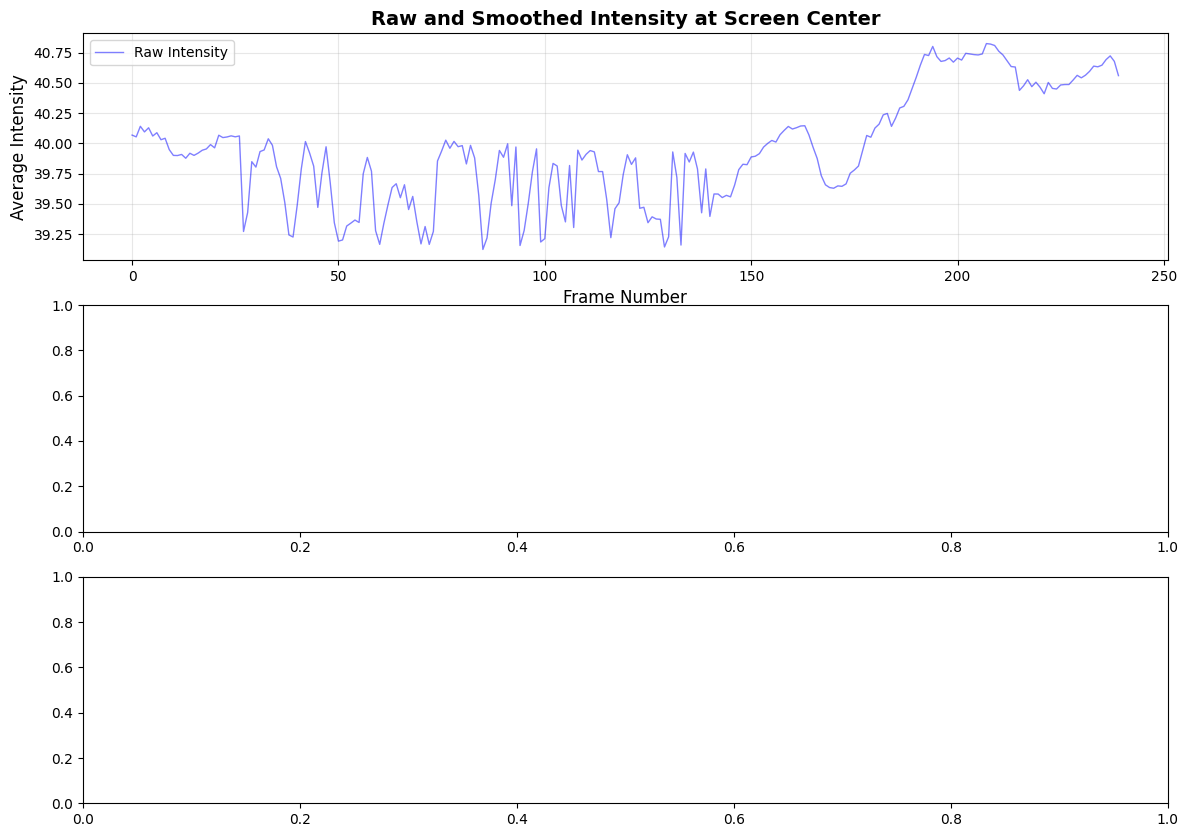

In [20]:
# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10))

# Raw intensity vs frame graph
ax1.plot(frame_numbers, intensities, 'b-', linewidth=1, alpha=0.5, label='Raw Intensity')
# ax1.plot(frame_numbers, smoothed_intensities, 'b-', linewidth=2, label='Smoothed Intensity')
ax1.set_xlabel('Frame Number', fontsize=12)
ax1.set_ylabel('Average Intensity', fontsize=12)
ax1.set_title('Raw and Smoothed Intensity at Screen Center', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

In [16]:
# Smoothed intensity with detected peaks and valleys
ax2.plot(frame_numbers, smoothed_intensities, 'b-', linewidth=2, label='Smoothed Intensity')
ax2.plot(valleys, smoothed_intensities[valleys], 'ro', markersize=8, label=f'Dark Fringes ({num_dark_fringes})')
ax2.plot(peaks, smoothed_intensities[peaks], 'go', markersize=8, label=f'Bright Fringes ({num_bright_fringes})')
ax2.set_xlabel('Frame Number', fontsize=12)
ax2.set_ylabel('Average Intensity', fontsize=12)
ax2.set_title('Detected Fringes at Screen Center', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

In [17]:
# Derivative graph
derivative = np.diff(smoothed_intensities)
ax3.plot(derivative, 'purple', linewidth=1.5)
ax3.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax3.set_xlabel('Frame Number', fontsize=12)
ax3.set_ylabel('Rate of Intensity Change', fontsize=12)
ax3.set_title('Intensity Derivative (Shows Direction of Movement)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

In [18]:
plt.tight_layout()
plt.savefig('fringe_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>


Graph saved as 'fringe_analysis.png'


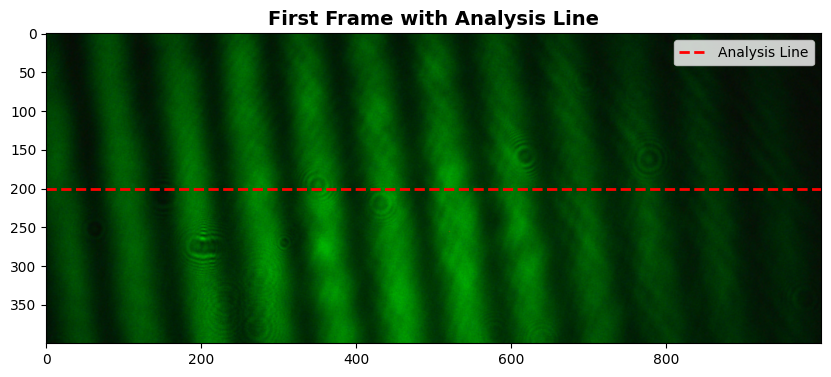

First frame saved as 'first_frame_verification.png'


In [19]:
print(f"\nGraph saved as 'fringe_analysis.png'")

# Optional: Show first frame for verification
first_frame_path = folder_path / "image_0000.png"
first_frame = cv2.imread(str(first_frame_path))
if first_frame is not None:
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    height, width = first_frame.shape[:2]
    plt.axhline(y=height//2, color='red', linestyle='--', linewidth=2, label='Analysis Line')
    plt.title('First Frame with Analysis Line', fontsize=14, fontweight='bold')
    plt.legend()
    plt.savefig('first_frame_verification.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("First frame saved as 'first_frame_verification.png'")